In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from functools import reduce
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

pd.set_option('display.max_columns', 120)
DATA_DIR = Path('data')
OUT_DIR = Path('processed')
OUT_DIR.mkdir(exist_ok=True)

In [6]:
# Load datasets
climate_files = [
    'Huye_climate_data.csv','Kigali_climate_data.csv','Muhanga_climate_data.csv',
    'Kibungo_climate_data.csv','Musanze_climate_data.csv','Nyagatare_climate_data.csv',
    'Rubavu_climate_data.csv','Rusizi_climate_data.csv'
]

climate_dfs = {}
for f in climate_files:
    loc = f.split('_')[0].lower()
    df = pd.read_csv(DATA_DIR / f, parse_dates=['Date'], na_values=['-999.0', -999.0])
    df.replace(-999.0, np.nan, inplace=True)
    climate_dfs[loc] = df

tomato = pd.read_csv(DATA_DIR / 'Tomato_price.csv', parse_dates=['Date'])
harvest = pd.read_csv(DATA_DIR / 'harvest_dataset.csv', parse_dates=['Date'])

print(f"Loaded {len(climate_dfs)} climate datasets, tomato: {tomato.shape}, harvest: {harvest.shape}")

Loaded 8 climate datasets, tomato: (2741, 6), harvest: (10000, 3)


/tmp/ipykernel_250824/2121326538.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_250824/2121326538.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Tomato columns: ['Date', 'Unit', 'Minimum', 'Maximum', 'Average', 'Market']


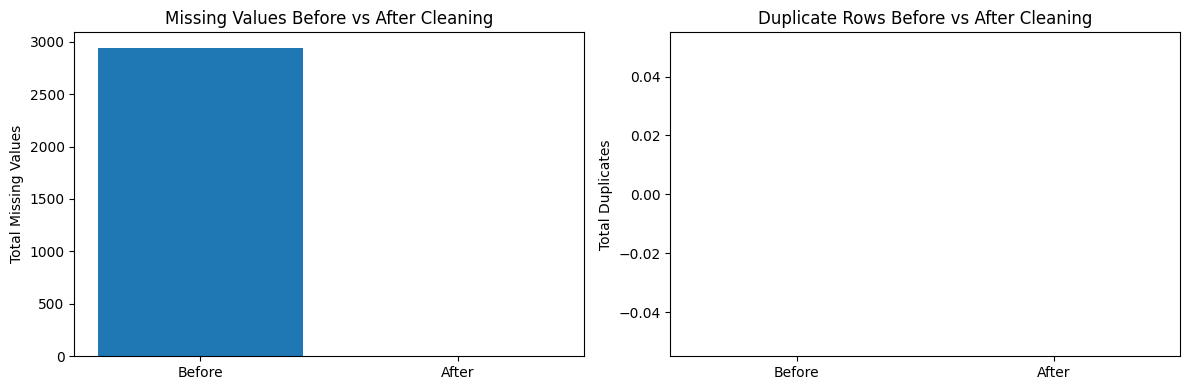

In [7]:
# 1. DATA CLEANING
missing_before = sum(df.isnull().sum().sum() for df in climate_dfs.values()) + tomato.isnull().sum().sum() + harvest.isnull().sum().sum()
duplicates_before = sum(df.duplicated().sum() for df in climate_dfs.values()) + tomato.duplicated().sum() + harvest.duplicated().sum()

# Clean climate data
for loc, df in climate_dfs.items():
    df.drop_duplicates(inplace=True)
    for col in df.select_dtypes(include='number').columns:
        df[col].fillna(df[col].median(), inplace=True)

# Clean tomato and harvest
print('Tomato columns:', tomato.columns.tolist())
tomato.drop_duplicates(inplace=True)
tomato['Average'] = pd.to_numeric(tomato['Average'], errors='coerce')
tomato['Average'].fillna(tomato['Average'].median(), inplace=True)

harvest.drop_duplicates(inplace=True)
harvest['Date'] = pd.to_datetime(harvest['Date']).dt.tz_localize(None)
for col in harvest.select_dtypes(include='number').columns:
    harvest[col].fillna(harvest[col].median(), inplace=True)

missing_after = sum(df.isnull().sum().sum() for df in climate_dfs.values()) + tomato.isnull().sum().sum() + harvest.isnull().sum().sum()
duplicates_after = sum(df.duplicated().sum() for df in climate_dfs.values()) + tomato.duplicated().sum() + harvest.duplicated().sum()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.bar(['Before', 'After'], [missing_before, missing_after])
plt.title('Missing Values Before vs After Cleaning')
plt.ylabel('Total Missing Values')

plt.subplot(1,2,2)
plt.bar(['Before', 'After'], [duplicates_before, duplicates_after])
plt.title('Duplicate Rows Before vs After Cleaning')
plt.ylabel('Total Duplicates')
plt.tight_layout()
plt.show()

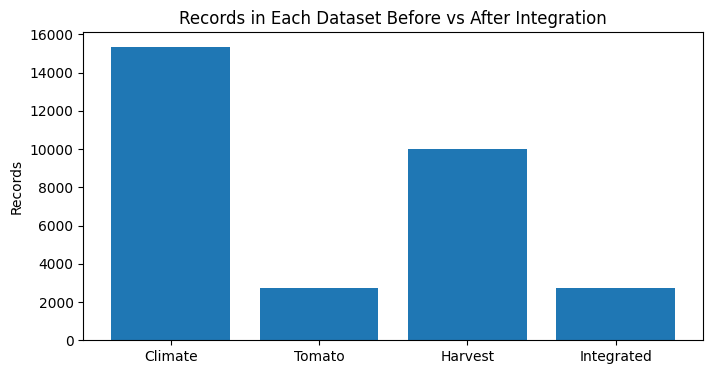

Integrated dataset shape: (2741, 12)


In [8]:
# 2. DATA INTEGRATION
# Rename and aggregate climate data
for loc, df in climate_dfs.items():
    df.rename(columns={'T2M':'temp_c','PRECTOTCORR':'precip_mm','WS2M':'wind_m_s','RH2M':'rh_pct','ALLSKY_SFC_SW_DWN':'sw_down'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.normalize()
    climate_dfs[loc] = df.groupby('Date').agg({'temp_c':'mean','precip_mm':'sum','wind_m_s':'mean','rh_pct':'mean','sw_down':'mean'}).reset_index()

# Merge all climate stations
all_daily = [df.rename(columns=lambda c: f"{loc}_{c}" if c!='Date' else c) for loc, df in climate_dfs.items()]
climate_all = reduce(lambda a,b: a.merge(b,on='Date',how='outer'), all_daily)

temp_cols = [c for c in climate_all.columns if c.endswith('temp_c')]
precip_cols = [c for c in climate_all.columns if c.endswith('precip_mm')]
wind_cols = [c for c in climate_all.columns if c.endswith('wind_m_s')]
rh_cols = [c for c in climate_all.columns if c.endswith('rh_pct')]

climate_avg = pd.DataFrame({
    'Date': climate_all['Date'],
    'temp_c': climate_all[temp_cols].mean(axis=1),
    'precip_mm': climate_all[precip_cols].sum(axis=1),
    'wind_m_s': climate_all[wind_cols].mean(axis=1),
    'rh_pct': climate_all[rh_cols].mean(axis=1)
}).drop_duplicates(subset=['Date']).sort_values('Date').reset_index(drop=True)

# Clean and merge tomato data
tomato.rename(columns={'Date':'Date','Average':'price_avg','Market':'market','Unit':'unit','Minimum':'min_price','Maximum':'max_price'}, inplace=True)
tomato['Date'] = pd.to_datetime(tomato['Date']).dt.normalize()

# Merge harvest data
harvest_daily = harvest.groupby('Date').agg({'Harvest_kg':'sum','Price_index':'mean'}).reset_index()

# Final integration
integrated_df = tomato.merge(climate_avg, on='Date', how='left').merge(harvest_daily, on='Date', how='left')
integrated_df[['Harvest_kg','Price_index']] = integrated_df[['Harvest_kg','Price_index']].ffill().bfill()

plt.figure(figsize=(8,4))
plt.bar(['Climate', 'Tomato', 'Harvest', 'Integrated'], [len(climate_avg), len(tomato), len(harvest_daily), len(integrated_df)])
plt.title('Records in Each Dataset Before vs After Integration')
plt.ylabel('Records')
plt.show()

print(f"Integrated dataset shape: {integrated_df.shape}")

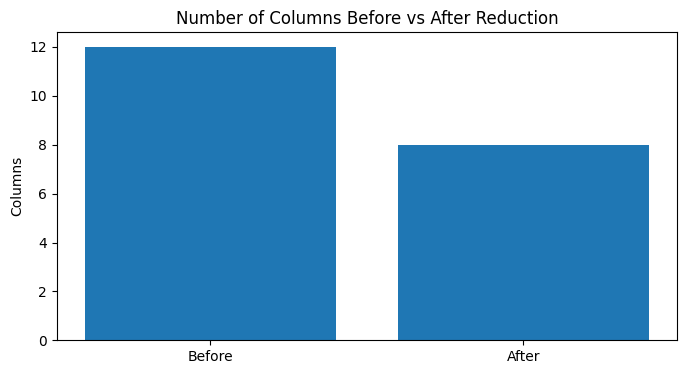

Reduced from 12 to 8 columns


In [9]:
# 3. DATA REDUCTION
reduce_cols = ['Date', 'price_avg', 'temp_c', 'precip_mm', 'wind_m_s', 'rh_pct', 'Harvest_kg', 'Price_index']
reduced_df = integrated_df[reduce_cols].copy()

plt.figure(figsize=(8,4))
plt.bar(['Before', 'After'], [integrated_df.shape[1], reduced_df.shape[1]])
plt.title('Number of Columns Before vs After Reduction')
plt.ylabel('Columns')
plt.show()

print(f"Reduced from {integrated_df.shape[1]} to {reduced_df.shape[1]} columns")

/home/benjamin/programming/urWork/farmer_sync_processing/venv/lib/python3.13/site-packages/sklearn/utils/_array_api.py:686: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/home/benjamin/programming/urWork/farmer_sync_processing/venv/lib/python3.13/site-packages/sklearn/utils/_array_api.py:706: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


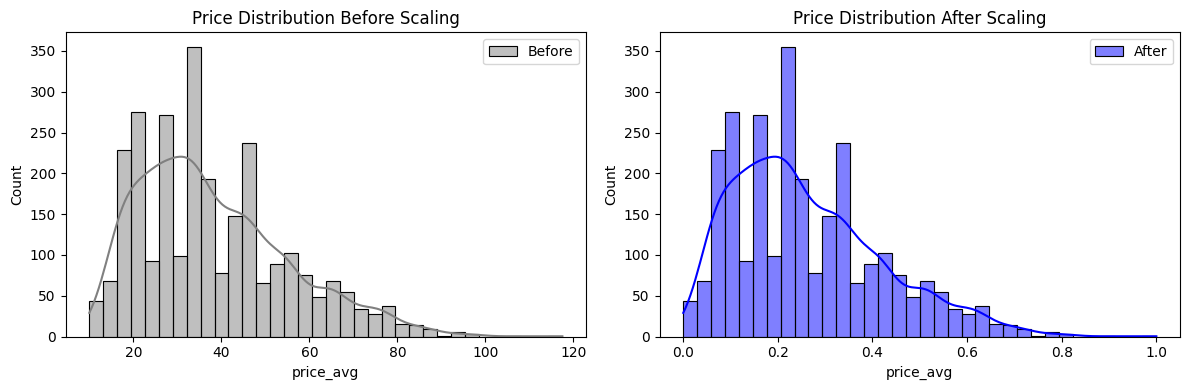

In [10]:
# 4. DATA TRANSFORMATION
scaler = MinMaxScaler()
numeric_cols = ['price_avg', 'temp_c', 'precip_mm', 'wind_m_s', 'rh_pct', 'Harvest_kg', 'Price_index']
reduced_df[numeric_cols] = scaler.fit_transform(reduced_df[numeric_cols])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(integrated_df['price_avg'].dropna(), kde=True, color='gray', label='Before')
plt.legend()
plt.title('Price Distribution Before Scaling')

plt.subplot(1,2,2)
sns.histplot(reduced_df['price_avg'], kde=True, color='blue', label='After')
plt.legend()
plt.title('Price Distribution After Scaling')
plt.tight_layout()
plt.show()

/tmp/ipykernel_250824/3938483911.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=reduced_df['temp_category'], palette='coolwarm')
/tmp/ipykernel_250824/3938483911.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=reduced_df['precip_category'], palette='Blues')


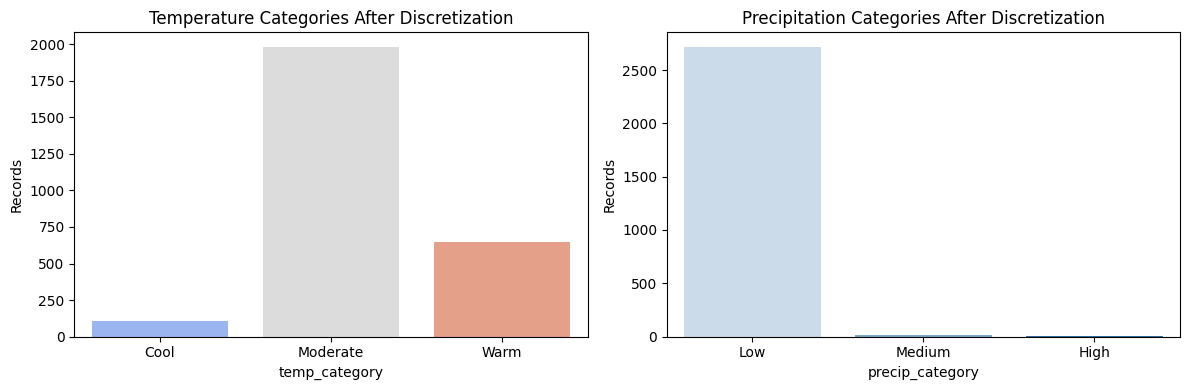

In [11]:
# 5. DATA DISCRETIZATION
reduced_df['temp_category'] = pd.cut(reduced_df['temp_c'], bins=3, labels=['Cool', 'Moderate', 'Warm'])
reduced_df['precip_category'] = pd.cut(reduced_df['precip_mm'], bins=3, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x=reduced_df['temp_category'], palette='coolwarm')
plt.title('Temperature Categories After Discretization')
plt.ylabel('Records')

plt.subplot(1,2,2)
sns.countplot(x=reduced_df['precip_category'], palette='Blues')
plt.title('Precipitation Categories After Discretization')
plt.ylabel('Records')
plt.tight_layout()
plt.show()

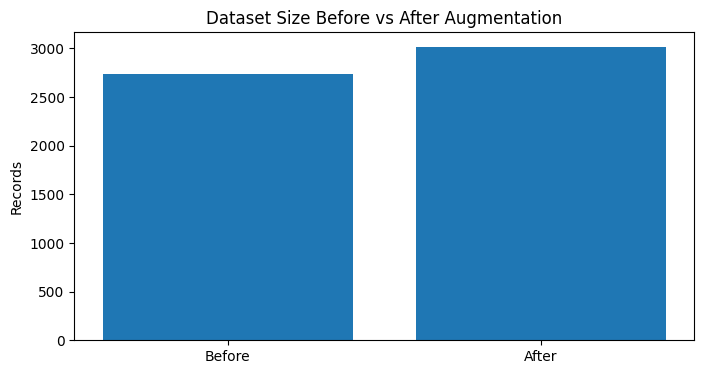

Final dataset shape: (3015, 11)
Original records: 2741
Synthetic records: 274


In [13]:
# 6. DATA AUGMENTATION
augmented = reduced_df.sample(frac=0.1, random_state=42)
augmented[numeric_cols] += np.random.normal(0, 0.05, size=(augmented.shape[0], len(numeric_cols)))
augmented['source'] = 'Synthetic'
reduced_df['source'] = 'Original'
augmented_df = pd.concat([reduced_df, augmented], ignore_index=True)

plt.figure(figsize=(8,4))
plt.bar(['Before', 'After'], [reduced_df.shape[0], augmented_df.shape[0]])
plt.title('Dataset Size Before vs After Augmentation')
plt.ylabel('Records')
plt.show()

print(f"Final dataset shape: {augmented_df.shape}")
print(f"Original records: {(augmented_df['source'] == 'Original').sum()}")
print(f"Synthetic records: {(augmented_df['source'] == 'Synthetic').sum()}")

In [14]:
# Save processed data
augmented_df.to_csv(OUT_DIR / 'processed_farmer_data.csv', index=False)
print(f"Processed data saved to {OUT_DIR / 'processed_farmer_data.csv'}")
print("\nFinal dataset summary:")
print(augmented_df.info())
print("\nFirst 5 rows:")
print(augmented_df.head())

Processed data saved to processed/processed_farmer_data.csv

Final dataset summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015 entries, 0 to 3014
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             3015 non-null   datetime64[ns]
 1   price_avg        3015 non-null   float64       
 2   temp_c           3015 non-null   float64       
 3   precip_mm        3015 non-null   float64       
 4   wind_m_s         3015 non-null   float64       
 5   rh_pct           3015 non-null   float64       
 6   Harvest_kg       0 non-null      float64       
 7   Price_index      0 non-null      float64       
 8   temp_category    3015 non-null   category      
 9   precip_category  3015 non-null   category      
 10  source           3015 non-null   object        
dtypes: category(2), datetime64[ns](1), float64(7), object(1)
memory usage: 218.3+ KB
None

First 5 rows:
        Date  